<a href="https://colab.research.google.com/github/apoorva2398/APS360-Project-Team-1-Winter-2019/blob/master/vggnew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Some parts of the code takn from transfer learning tutorial on pytorch website

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

data_dir = '/content/gdrive/My Drive/APS360 Project Shared Folder/Data/Cropped ROI Data/data (resized to 224 x 224 x 3, two classes, tif)'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



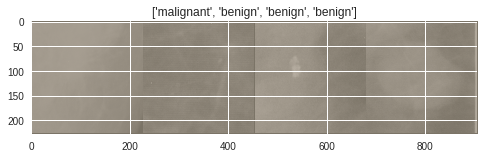

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 88916881.15it/s]


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [0]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: ignored

In [0]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [0]:
models.vgg16(pretrained=True)

In [0]:
vgg = models.vgg16(pretrained=True)
for param in vgg.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

vgg.classifier = nn.Linear(25088, 2)

vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_vgg = optim.SGD(vgg.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

In [0]:
train_model(vgg, criterion, optimizer_vgg,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


KeyboardInterrupt: ignored

In [0]:
visualize_model(vgg)

plt.ioff()
plt.show()

Change loss function

In [0]:
vgg2 = models.vgg16(pretrained=True)
for param in vgg2.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default


vgg2.classifier = nn.Sequential(
                        nn.Linear(25088, 4096), #fully connected layer; input_size = 25088; output_size = 256
                        nn.ReLU(), #ReLU activation
                        nn.Dropout(0.5), # 40% dropout rate
                        nn.Linear(4096, 2)) # log softmax to produce a probability 
                        

                
vgg2 = vgg2.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_vgg2 = optim.SGD(vgg2.classifier.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer_vgg2, step_size=7, gamma=0.1)

In [0]:
train_model(vgg2, criterion, optimizer_vgg2, exp_lr_scheduler2, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.6043 Acc: 0.6560
validation Loss: 0.6086 Acc: 0.6510

Epoch 1/14
----------
train Loss: 0.5761 Acc: 0.6888
validation Loss: 0.5977 Acc: 0.6684

Epoch 2/14
----------
train Loss: 0.5596 Acc: 0.7014
validation Loss: 0.5888 Acc: 0.6719

Epoch 3/14
----------
train Loss: 0.5419 Acc: 0.7233
validation Loss: 0.5916 Acc: 0.6597

Epoch 4/14
----------
train Loss: 0.5304 Acc: 0.7302
validation Loss: 0.5855 Acc: 0.6649

Epoch 5/14
----------
train Loss: 0.5178 Acc: 0.7385
validation Loss: 0.6088 Acc: 0.6614

Epoch 6/14
----------
train Loss: 0.4909 Acc: 0.7538
validation Loss: 0.5729 Acc: 0.6859

Epoch 7/14
----------
train Loss: 0.4848 Acc: 0.7669
validation Loss: 0.5710 Acc: 0.6824

Epoch 8/14
----------
train Loss: 0.4855 Acc: 0.7717
validation Loss: 0.5724 Acc: 0.6789

Epoch 9/14
----------
train Loss: 0.4813 Acc: 0.7691
validation Loss: 0.5707 Acc: 0.6894

Epoch 10/14
----------
train Loss: 0.4827 Acc: 0.7643
validation Loss: 0.5713 Acc: 0.6806

Epoch 11/

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

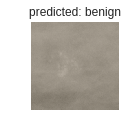

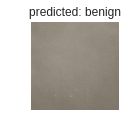

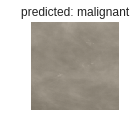

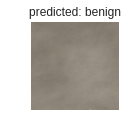

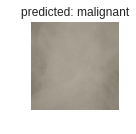

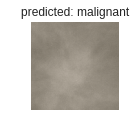

In [0]:
visualize_model(vgg2)

plt.ioff()
plt.show()

In [0]:
vgg3 = models.vgg16(pretrained=True)
for param in vgg3.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default


vgg3.classifier = nn.Sequential(
                        nn.Linear(25088, 4096), #fully connected layer; input_size = 25088; output_size = 256
                        nn.ReLU(), #ReLU activation
                        nn.Dropout(0.5), # 40% dropout rate
                        nn.Linear(4096, 256),
                        nn.ReLU(), #ReLU activation
                        nn.Dropout(0.4), # 40% dropout rate
                        nn.Linear(256, 2)) # log softmax to produce a probability 
                        

                
vgg3 = vgg3.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_vgg3 = optim.SGD(vgg3.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler3 = lr_scheduler.StepLR(optimizer_vgg3, step_size=7, gamma=0.1)

In [0]:
train_model(vgg3, criterion, optimizer_vgg3, exp_lr_scheduler3, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6482 Acc: 0.5989
validation Loss: 0.6257 Acc: 0.6161

Epoch 1/19
----------
train Loss: 0.6083 Acc: 0.6434
validation Loss: 0.6607 Acc: 0.6073

Epoch 2/19
----------
train Loss: 0.5854 Acc: 0.6787
validation Loss: 0.5980 Acc: 0.6545

Epoch 3/19
----------
train Loss: 0.5662 Acc: 0.6897
validation Loss: 0.5794 Acc: 0.6754

Epoch 4/19
----------
train Loss: 0.5533 Acc: 0.6914
validation Loss: 0.5748 Acc: 0.6771

Epoch 5/19
----------
train Loss: 0.5278 Acc: 0.7150
validation Loss: 0.6785 Acc: 0.6492

Epoch 6/19
----------
train Loss: 0.5251 Acc: 0.7167
validation Loss: 0.5830 Acc: 0.6667

Epoch 7/19
----------
train Loss: 0.4657 Acc: 0.7665
validation Loss: 0.5829 Acc: 0.6736

Epoch 8/19
----------
train Loss: 0.4490 Acc: 0.7778
validation Loss: 0.5809 Acc: 0.6928

Epoch 9/19
----------
train Loss: 0.4315 Acc: 0.7870
validation Loss: 0.5897 Acc: 0.6859

Epoch 10/19
----------
train Loss: 0.4184 Acc: 0.7975
validation Loss: 0.5849 Acc: 0.6946

Epoch 11/

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
train_model(vgg3, criterion, optimizer_vgg3, exp_lr_scheduler3, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6436 Acc: 0.6050
validation Loss: 0.6328 Acc: 0.6003

Epoch 1/24
----------
train Loss: 0.6124 Acc: 0.6464
validation Loss: 0.6048 Acc: 0.6510

Epoch 2/24
----------
train Loss: 0.5842 Acc: 0.6713
validation Loss: 0.5968 Acc: 0.6597

Epoch 3/24
----------
train Loss: 0.5698 Acc: 0.6918
validation Loss: 0.5900 Acc: 0.6597

Epoch 4/24
----------
train Loss: 0.5513 Acc: 0.6962
validation Loss: 0.6082 Acc: 0.6370

Epoch 5/24
----------
train Loss: 0.5268 Acc: 0.7102
validation Loss: 0.6084 Acc: 0.6440

Epoch 6/24
----------
train Loss: 0.5241 Acc: 0.7215
validation Loss: 0.5660 Acc: 0.6946

Epoch 7/24
----------
train Loss: 0.5089 Acc: 0.7228
validation Loss: 0.5899 Acc: 0.6492

Epoch 8/24
----------
train Loss: 0.4926 Acc: 0.7381
validation Loss: 0.5742 Acc: 0.6859

Epoch 9/24
----------
train Loss: 0.4767 Acc: 0.7529
validation Loss: 0.6017 Acc: 0.6527

Epoch 10/24
----------
train Loss: 0.4509 Acc: 0.7652
validation Loss: 0.5637 Acc: 0.6841

Epoch 11/

KeyboardInterrupt: ignored

In [0]:
vgg4 = models.vgg16(pretrained=True)
for param in vgg4.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default


vgg4.classifier = nn.Sequential(
                        nn.Linear(25088, 4096), #fully connected layer; input_size = 25088; output_size = 256
                        nn.ReLU(), #ReLU activation
                        nn.Linear(4096, 256),
                        nn.ReLU(), #ReLU activation
                        nn.Linear(256, 2)) # log softmax to produce a probability 
                        

                
vgg4 = vgg4.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_vgg4 = optim.SGD(vgg4.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler4 = lr_scheduler.StepLR(optimizer_vgg4, step_size=7, gamma=0.1)

In [0]:
train_model(vgg4, criterion, optimizer_vgg4, exp_lr_scheduler4, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6307 Acc: 0.6181
validation Loss: 0.6145 Acc: 0.6597

Epoch 1/24
----------
train Loss: 0.5796 Acc: 0.6761
validation Loss: 0.5899 Acc: 0.6754

Epoch 2/24
----------
train Loss: 0.5380 Acc: 0.7041
validation Loss: 0.6416 Acc: 0.6475

Epoch 3/24
----------
train Loss: 0.5053 Acc: 0.7460
validation Loss: 0.5763 Acc: 0.6824

Epoch 4/24
----------
train Loss: 0.4731 Acc: 0.7647
validation Loss: 0.5728 Acc: 0.6824

Epoch 5/24
----------
train Loss: 0.4375 Acc: 0.7783
validation Loss: 0.5662 Acc: 0.7051

Epoch 6/24
----------
train Loss: 0.4065 Acc: 0.8027
validation Loss: 0.7853 Acc: 0.6649

Epoch 7/24
----------
train Loss: 0.2943 Acc: 0.8708
validation Loss: 0.6281 Acc: 0.6981

Epoch 8/24
----------


KeyboardInterrupt: ignored

In [0]:
visualize_model(vgg3)

plt.ioff()
plt.show()

NameError: ignored

In [0]:
vgg5 = models.vgg16(pretrained=True)
for param in vgg5.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default


vgg5.classifier = nn.Sequential(
                        nn.Linear(25088, 10000), #fully connected layer; input_size = 25088; output_size = 2
                        nn.ReLU(), #ReLU activation
                        nn.Linear(10000, 2000),
                        nn.ReLU(), #ReLU activation
                        nn.Linear(2000, 200),
                        nn.ReLU(), #ReLU activation
                        nn.Linear(200, 2)) # log softmax to produce a probability 
                        

                
vgg5 = vgg5.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_vgg5 = optim.SGD(vgg5.classifier.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler5 = lr_scheduler.StepLR(optimizer_vgg5, step_size=7, gamma=0.1)

In [0]:
train_model(vgg5, criterion, optimizer_vgg5, exp_lr_scheduler5, num_epochs=25)

NameError: ignored

In [0]:
vgg5 = models.vgg16(pretrained=True)
for param in vgg5.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default


vgg5.classifier = nn.Sequential(
                        nn.Linear(25088, 10000), #fully connected layer; input_size = 25088; output_size = 2
                        nn.ReLU(), #ReLU activation
                        nn.Linear(10000, 2000),
                        nn.ReLU(), #ReLU activation
                        nn.Linear(2000, 200),
                        nn.ReLU(), #ReLU activation
                        nn.Linear(200, 2)) # log softmax to produce a probability 
                        

                
vgg5 = vgg5.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_vgg5 = optim.SGD(vgg5.classifier.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler5 = lr_scheduler.StepLR(optimizer_vgg5, step_size=7, gamma=0.1)

In [0]:
import torch.nn.functional as F

In [0]:
//TRY CONVO AND FC YOUJR OWN IMPLEMENTATION

In [0]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "linear1"
        self.layer1 = nn.Linear(224 * 224 *3, 1000)
        self.layer2 = nn.Linear(1000, 200)
        self.layer3 = nn.Linear(200, 20)
        self.layer4 = nn.Linear(20, 2)
    def forward(self, img):
        flattened = img.view(-1, 224 * 224 *3)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = F.relu(self.layer3(activation2))
        output = self.layer4(activation3)
        return output

In [0]:
linear1 = LinearNet()

In [0]:
linear1 = linear1.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_lin = optim.SGD(linear1.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_lin = lr_scheduler.StepLR(optimizer_lin, step_size=7, gamma=0.1)

In [0]:
train_model(linear1, criterion, optimizer_lin, exp_lr_scheduler_lin, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6787 Acc: 0.5884
validation Loss: 0.6762 Acc: 0.6073

Epoch 1/24
----------
train Loss: 0.6710 Acc: 0.5962
validation Loss: 0.6716 Acc: 0.5707

Epoch 2/24
----------
train Loss: 0.6630 Acc: 0.5971
validation Loss: 0.6804 Acc: 0.5707

Epoch 3/24
----------
train Loss: 0.6576 Acc: 0.6002
validation Loss: 0.6988 Acc: 0.5689

Epoch 4/24
----------
train Loss: 0.6566 Acc: 0.6076
validation Loss: 0.6506 Acc: 0.5951

Epoch 5/24
----------
train Loss: 0.6580 Acc: 0.6045
validation Loss: 0.6537 Acc: 0.5934

Epoch 6/24
----------
train Loss: 0.6506 Acc: 0.6189
validation Loss: 0.6739 Acc: 0.5707

Epoch 7/24
----------
train Loss: 0.6432 Acc: 0.6220
validation Loss: 0.6386 Acc: 0.6091

Epoch 8/24
----------
train Loss: 0.6381 Acc: 0.6285
validation Loss: 0.6377 Acc: 0.6108

Epoch 9/24
----------
train Loss: 0.6378 Acc: 0.6333
validation Loss: 0.6361 Acc: 0.6126

Epoch 10/24
----------
train Loss: 0.6366 Acc: 0.6229
validation Loss: 0.6348 Acc: 0.6091

Epoch 11/

KeyboardInterrupt: ignored

In [0]:
class LinearNet2(nn.Module):
    def __init__(self):
        super(LinearNet2, self).__init__()
        self.name = "linear2"
        self.layer1 = nn.Linear(224 * 224 *3, 50000)
        self.layer2 = nn.Linear(50000, 5000)
        self.layer3 = nn.Linear(5000, 500)
        self.layer4 = nn.Linear(500, 50)
        self.layer5 = nn.Linear(50, 2)
    def forward(self, img):
        flattened = img.view(-1, 224 * 224 *3)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        activation3 = F.relu(self.layer3(activation2))
        activation4 = F.relu(self.layer3(activation3))
        output = self.layer5(activation4)
        return output

In [0]:
linear2 = LinearNet2()
linear2 = linear2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_lin2 = optim.SGD(linear2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_lin2 = lr_scheduler.StepLR(optimizer_lin2, step_size=7, gamma=0.1)

In [0]:
train_model(linear2, criterion, optimizer_lin2, exp_lr_scheduler_lin2, num_epochs=25)

In [0]:
class CNNet2(nn.Module):
    def __init__(self):
        super(CNNet2, self).__init__()
        self.name = "cnn2"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5 * 110 * 110, 200)
        self.fc2 = nn.Linear(200, 75)
        self.fc3 = nn.Linear(75, 30)
        self.fc4 = nn.Linear(30, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print (x.shape)
        x = x.view(-1, 5 * 110 * 110)
        #print (x.shape)
        x = F.relu(self.fc1(x))
        #print (x.shape)
        x = F.relu(self.fc2(x))
        #print (x.shape)
        x = F.relu(self.fc3(x))
        #print (x.shape)
        x = self.fc4(x)
        #print (x.shape)
        x = x.squeeze(1) # Flatten to [batch_size]
        #print (x.shape)
        return x

In [0]:
cnn2 = CNNet2()
cnn2 = cnn2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_cnn2 = optim.SGD(cnn2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_cnn2 = lr_scheduler.StepLR(optimizer_cnn2, step_size=7, gamma=0.1)

In [0]:
train_model(cnn2, criterion, optimizer_cnn2, exp_lr_scheduler_cnn2, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9306 Acc: 0.5692
validation Loss: 0.6826 Acc: 0.5707

Epoch 1/24
----------
train Loss: 0.7022 Acc: 0.5618
validation Loss: 0.6984 Acc: 0.5271

Epoch 2/24
----------
train Loss: 0.6944 Acc: 0.5823
validation Loss: 0.6909 Acc: 0.5707

Epoch 3/24
----------
train Loss: 0.6859 Acc: 0.5814
validation Loss: 0.7033 Acc: 0.5707

Epoch 4/24
----------
train Loss: 0.6836 Acc: 0.5823
validation Loss: 0.6785 Acc: 0.5829

Epoch 5/24
----------
train Loss: 0.6796 Acc: 0.5853
validation Loss: 0.7027 Acc: 0.5707

Epoch 6/24
----------
train Loss: 0.6780 Acc: 0.5845
validation Loss: 0.6628 Acc: 0.6108

Epoch 7/24
----------
train Loss: 0.6546 Acc: 0.6211
validation Loss: 0.6588 Acc: 0.5899

Epoch 8/24
----------
train Loss: 0.6513 Acc: 0.6233
validation Loss: 0.6635 Acc: 0.5777

Epoch 9/24
----------
train Loss: 0.6512 Acc: 0.6159
validation Loss: 0.6494 Acc: 0.6021

Epoch 10/24
----------
train Loss: 0.6508 Acc: 0.6150
validation Loss: 0.6556 Acc: 0.5934

Epoch 11/

CNNet2(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=60500, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=75, bias=True)
  (fc3): Linear(in_features=75, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=9, bias=True)
)